## MFC First-Level GLM

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Obtain first level model objects automatically from BIDS (MFC)

from nilearn.glm.first_level import first_level_from_bids

def get_models(task):

    return first_level_from_bids(
            dataset_path='/Volumes/Seagate_Desktop_Drive/mfc/rawdata/',
            derivatives_folder='/Volumes/Seagate_Desktop_Drive/mfc/derivatives/fmriprep',
            task_label=task,
            space_label='MNI152NLin2009cAsym',
            t_r=2,
            smoothing_fwhm=6)

# h1

models, models_run_imgs, models_events, models_confounds = get_models('h1')

# append h2, h3, h4

for heat in ['h2','h3','h4']:
    var1 = get_models(heat)
    models.extend(var1[0])
    models_run_imgs.extend(var1[1])
    models_events.extend(var1[2])
    models_confounds.extend(var1[3])
    

In [4]:
# Get Confounds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.glm.first_level import make_first_level_design_matrix

# extract selected confounds

from load_confounds import Confounds 

hmp_compcor_scrub = {'strategy': ['high_pass', 'motion', 'compcor', 'scrub'],    #'compcor' 'wm_csf' 'global'
                    'motion': 'basic',
                    'compcor': 'anat',           # anatomical compcor based on masks
                    'n_compcor': 1,              # 'auto' = enough components to explain 50% of variance
                    'acompcor_combined': True,   # combine WM and CSF masks
                    #'wm_csf': 'basic',
                    'scrub': 'basic',
                    'fd_thresh': 0.9,            # scrubs volumes > 0.9 mm
                    'std_dvars_thresh': None}
                    #'global_signal': 'basic'}    # scrubs volumes > 3 std devs

confounds = Confounds(**hmp_compcor_scrub).load([i[0] for i in models_run_imgs])

In [ ]:
#Confounds?

In [12]:
# Create Design Matrices & Fit GLM (First Level)

frame_times = np.linspace(0,292,147)    # create volume start time matrix

z_maps = []

from nilearn.glm.first_level import FirstLevelModel
fmri_glm = FirstLevelModel(smoothing_fwhm=6, standardize=True, high_pass=None, n_jobs=-2, verbose=0)

for model_event, confound, model_run_img in zip(models_events, confounds, models_run_imgs):
    dm = make_first_level_design_matrix(
        frame_times,
        events=model_event[0],
        hrf_model='glover',
        drift_model=None,
        high_pass=None,
        #drift_order=1,
        #fir_delays=[0],
        add_regs=confound,
        add_reg_names=None,
        min_onset=-24,
        oversampling=50,
    )
        
    fmri_glm = fmri_glm.fit(model_run_img, design_matrices = dm)    # fit GLM per run
    
    # read # cols from dm and build contrast with 1 and 0's: 49 > 35 t-test
    contrast = np.zeros(len(dm.columns))
    contrast[0] = 1
    z_map = fmri_glm.compute_contrast(contrast, output_type='z_score')
    
    file = '/Volumes/Seagate_Desktop_Drive/mfc/GLM/First_Levels/' + model_run_img[0].split('/')[-1][:-7] + '_zmap_49v35.nii.gz'
    print(file)
    
    z_map.to_filename(file)

    z_maps.append(z_map)

# Plot design matrix
# plotting.plot_design_matrix(data_matrices[0])

/Volumes/Seagate_Desktop_Drive/mfc/GLM/First_Levels/sub-mfcc003_task-h1_acq-epi_rec-fmap_space-MNI152NLin2009cAsym_desc-preproc_bold_zmap_49v35.nii.gz
/Volumes/Seagate_Desktop_Drive/mfc/GLM/First_Levels/sub-mfcc006_task-h1_acq-epi_rec-fmap_space-MNI152NLin2009cAsym_desc-preproc_bold_zmap_49v35.nii.gz
/Volumes/Seagate_Desktop_Drive/mfc/GLM/First_Levels/sub-mfcc007_task-h1_acq-epi_rec-fmap_space-MNI152NLin2009cAsym_desc-preproc_bold_zmap_49v35.nii.gz
/Volumes/Seagate_Desktop_Drive/mfc/GLM/First_Levels/sub-mfcc011_task-h1_acq-epi_rec-fmap_space-MNI152NLin2009cAsym_desc-preproc_bold_zmap_49v35.nii.gz
/Volumes/Seagate_Desktop_Drive/mfc/GLM/First_Levels/sub-mfcc014_task-h1_acq-epi_rec-fmap_space-MNI152NLin2009cAsym_desc-preproc_bold_zmap_49v35.nii.gz
/Volumes/Seagate_Desktop_Drive/mfc/GLM/First_Levels/sub-mfcc016_task-h1_acq-epi_rec-fmap_space-MNI152NLin2009cAsym_desc-preproc_bold_zmap_49v35.nii.gz
/Volumes/Seagate_Desktop_Drive/mfc/GLM/First_Levels/sub-mfcc024_task-h1_acq-epi_rec-fmap_space


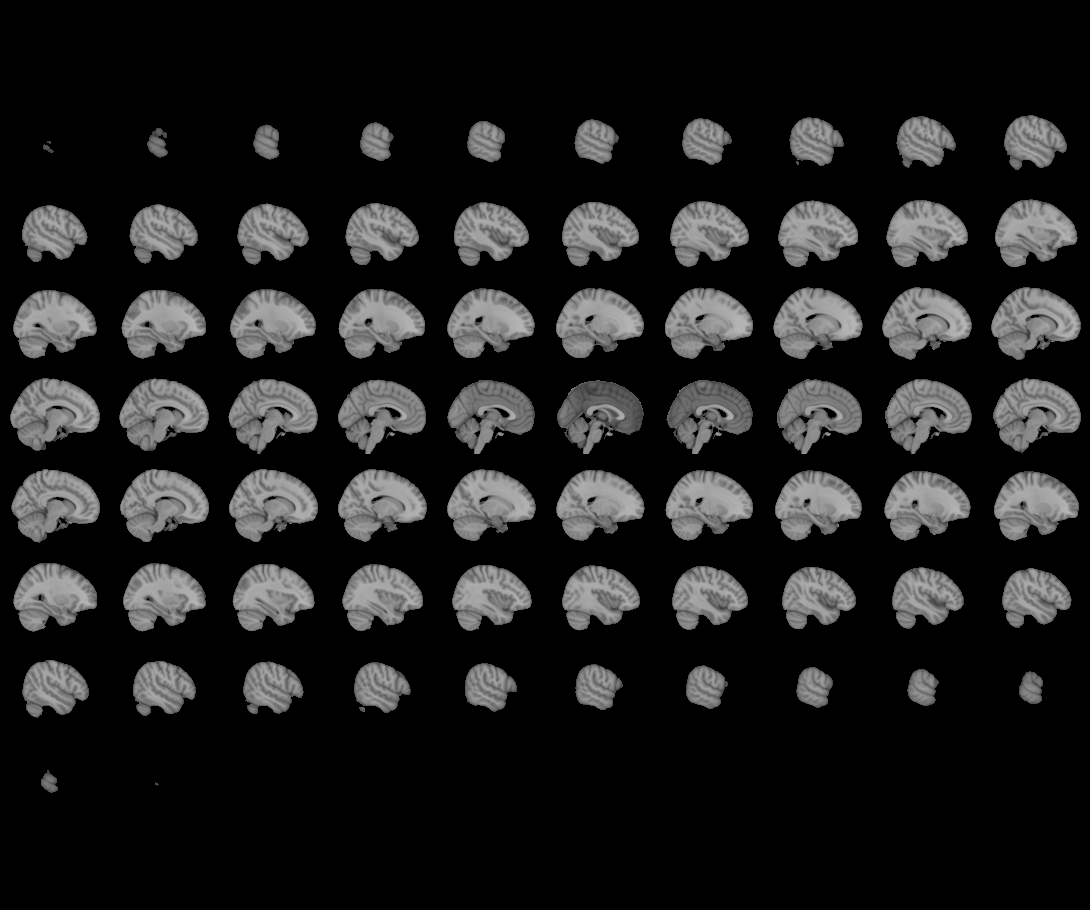
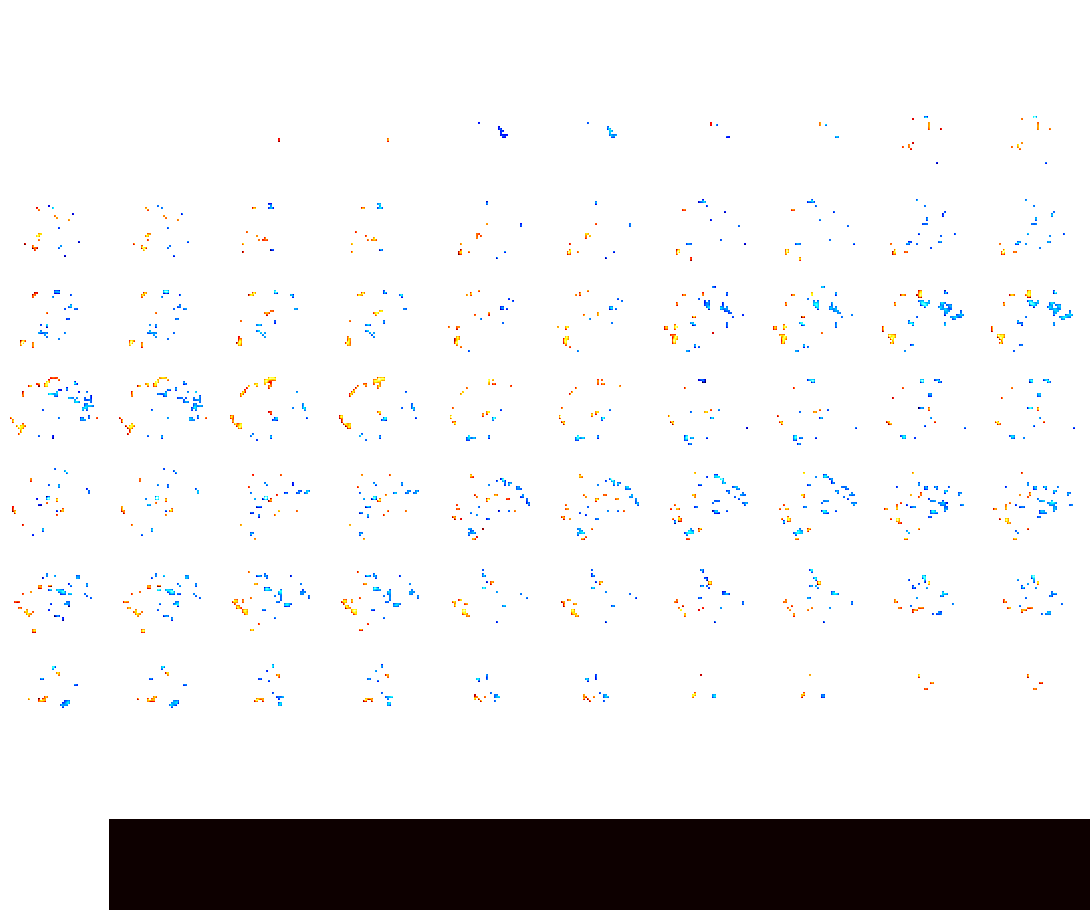

In [13]:
# Plot sample sub/run contrast z-map

plotting.view_img(
    z_maps[110], threshold=3.0, display_mode='z')

In [14]:
# Run sample report for last run

fmri_glm.generate_report(contrast)

drift_model,cosine
drift_order,1
fir_delays,[0]
high_pass (Hz),None
hrf_model,glover
noise_model,ar1
scaling_axis,0
signal_scaling,True
slice_time_ref,0
smoothing_fwhm,6
standardize,False
